##### End-to-End Data Cleaning Pipeline with Raha and Baran (Detailed Demo)
We build an end-to-end data cleaning pipeline with our configuration-free error detection and correction systems, Raha and Baran.

**For this notebook to work, raha must have already run once on the HISTORICAL_DATASETS and the main dataset. 
In this notebook, these are the flights, beers, hospital datasets.**

In [1]:
import bz2
import json
import pickle

import numpy
import pandas
import ipywidgets
import IPython.display
import sklearn.decomposition
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt

import raha

## 1. Instantiating the Detection and Correction Classes
We first instantiate the `Detection` and `Correction` classes.

In [2]:
app_1 = raha.dask_version.detection_parallel.Detection()
app_2 = raha.dask_version.correction_parallel.Correction()

# How many tuples would you label?
app_1.LABELING_BUDGET = 20
app_2.LABELING_BUDGET = 0

# Would you like to see the logs?
app_1.VERBOSE = True
app_2.VERBOSE = True

# Do you want to filter out ineffective error detector strategies?
app_1.STRATEGY_FILTERING = True
app_1.HISTORICAL_DATASETS = [
    {
        "name": "movies_1",
        "path": "../datasets/movies_1/dirty.csv",
        "clean_path": "../datasets/movies_1/clean.csv"
    },
    {
        "name": "rayyan",
        "path": "../datasets/rayyan/dirty.csv",
        "clean_path": "../datasets/rayyan/clean.csv"
    }
]

# Do you have any pretrained error corrector models to load?
PRETRAINED_VALUE_BASED_MODELS_PATH = "../supplementaries/models/pretrained_value_based_models.dictionary"
pretrained_models = pickle.load(bz2.BZ2File(PRETRAINED_VALUE_BASED_MODELS_PATH, "rb"))

## 2. Instantiating the Dataset
We next load and instantiate the dataset object.

In [3]:
dataset_dictionary = {
    "name": "flights",
    "path": "../datasets/flights/dirty.csv",
    "clean_path": "../datasets/flights/clean.csv"
}
d = app_1.initialize_dataset(dataset_dictionary)
d.dataframe.head()

,tuple_id,src,flight,sched_dep_time,act_dep_time,sched_arr_time,act_arr_time
0,1,aa,AA-3859-IAH-ORD,7:10 a.m.,7:16 a.m.,9:40 a.m.,9:32 a.m.
1,2,aa,AA-1733-ORD-PHX,7:45 p.m.,7:58 p.m.,10:30 p.m.,
2,3,aa,AA-1640-MIA-MCO,6:30 p.m.,,7:25 p.m.,
3,4,aa,AA-518-MIA-JFK,6:40 a.m.,6:54 a.m.,9:25 a.m.,9:28 a.m.
4,5,aa,AA-3756-ORD-SLC,12:15 p.m.,12:41 p.m.,2:45 p.m.,2:50 p.m.


## 3. Running Error Detection Strategies
Raha runs (all or the promising) error detection strategies on the dataset. This step could take a while because all the strategies should be run on the dataset. 

In [4]:
app_1.run_strategies(d)

237 strategy profiles are collected.


,Name,Score,New Column,Historical Column
0,"[""Outlier Detection"", [""gaussian"", ""2.7""]]",0.960752,flights.tuple_id,rayyan.article_jvolumn
1,"[""Outlier Detection"", [""gaussian"", ""3.0""]]",0.960752,flights.tuple_id,rayyan.article_jvolumn
2,"[""Outlier Detection"", [""histogram"", ""0.9"", ""0....",0.909278,flights.tuple_id,movies_1.year
3,"[""Outlier Detection"", [""histogram"", ""0.3"", ""0....",0.909278,flights.tuple_id,movies_1.year
4,"[""Outlier Detection"", [""histogram"", ""0.9"", ""0....",0.909278,flights.tuple_id,movies_1.year


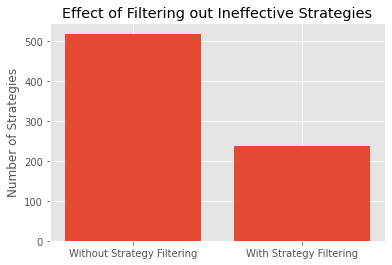

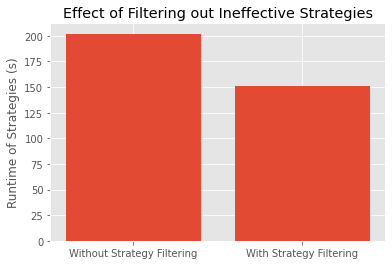

In [5]:
optimized_strategies_count = len(d.strategy_profiles)
optimized_runtime = sum([sp["runtime"] for sp in d.strategy_profiles])
original_strategies_count, original_runtime = raha.original.utilities.get_strategies_count_and_runtime(dataset_dictionary)
approaches = ["Without Strategy Filtering", "With Strategy Filtering"]

plt.style.use("ggplot")
fig = plt.figure()
ax = plt.axes()
x_pos = [0, 1]
ax.bar(x_pos, [original_strategies_count, optimized_strategies_count])
ax.set(ylabel="Number of Strategies", title="Effect of Filtering out Ineffective Strategies");
ax.set_xticks(numpy.arange(len(x_pos)))
_ = ax.set_xticklabels(approaches, rotation=0)

plt.style.use("ggplot")
fig = plt.figure()
ax = plt.axes()
x_pos = [0, 1]
ax.bar(x_pos, [original_runtime, optimized_runtime])
ax.set(ylabel="Runtime of Strategies (s)", title="Effect of Filtering out Ineffective Strategies");
ax.set_xticks(numpy.arange(len(x_pos)))
_ = ax.set_xticklabels(approaches, rotation=0)

strategies_df = pandas.DataFrame(columns=["Name", "Score", "New Column", "Historical Column"])
for sp in d.strategy_profiles:
    strategies_df = pandas.concat([strategies_df, pandas.DataFrame({"Name": sp["name"].replace("OD", "Outlier Detection").replace(
        "PVD", "Pattern Violation Detection").replace("RVD", "Rule Violation Detection").replace(
        "KBVD", "Knowledge Base Violation Detection"), "Score": sp["score"], "New Column": sp["new_column"], 
                                          "Historical Column": sp["historical_column"]}, index=[0])], ignore_index=True)
strategies_df.head()

## 4. Generating Features
Raha then generates a feature vector for each data cell based on the output of error detection strategies. 

In [6]:
app_1.generate_features(d)

25 Features are generated for column 0.
9 Features are generated for column 1.
22 Features are generated for column 2.
24 Features are generated for column 3.
24 Features are generated for column 4.
25 Features are generated for column 5.
36 Features are generated for column 6.


In [7]:
def callback(row, column):
    selected_tuple = pandas.DataFrame(data=[d.dataframe.iloc[int(row), :]], columns=d.dataframe.columns)
    IPython.display.display(selected_tuple)
    features_df = pandas.DataFrame(columns=["Name", "Value"])
    for strategy_profile in d.strategy_profiles:
        strategy_name = json.loads(strategy_profile["name"])
        value = 0
        for cell in strategy_profile["output"]:
            if cell == (int(row), int(column)):
                value = 1
        features_df = pandas.concat([features_df, pandas.DataFrame({"Name": strategy_name, "Value": value})], ignore_index=True)
    IPython.display.display(features_df.sort_values("Value", ascending=False))

interactive_text = ipywidgets.interactive(callback, row="100", column="6")
interactive_text

interactive(children=(Text(value='100', description='row'), Text(value='6', description='column'), Output()), …

## 5. Building Clusters
Raha next builds a hierarchical clustering model for our clustering-based sampling approach.

In [8]:
app_1.build_clusters(d)

A hierarchical clustering model is built for column 0.
A hierarchical clustering model is built for column 1.
A hierarchical clustering model is built for column 2.
A hierarchical clustering model is built for column 3.
A hierarchical clustering model is built for column 4.
A hierarchical clustering model is built for column 5.
A hierarchical clustering model is built for column 6.


In [9]:
def callback(attribute):
    column = d.dataframe.columns.get_loc(attribute)
    features = d.column_features[column]    
    plt.figure(figsize=(20, 7))
    plt.title("Data Cells Dendograms")
    linkage = scipy.cluster.hierarchy.linkage(features[:50], method="average")
    dend = scipy.cluster.hierarchy.dendrogram(linkage, labels=range(50))

_ = ipywidgets.interact(callback, attribute=ipywidgets.Dropdown(options=d.dataframe.columns, value=d.dataframe.columns[-1]))

interactive(children=(Dropdown(description='attribute', index=6, options=('tuple_id', 'src', 'flight', 'sched_…

In [10]:
def inspect_features(cell_list):
    features_df = pandas.DataFrame(columns=["Cell", "Value", "Strategies"])
    for c in cell_list:
        strategies = []
        for strategy_profile in d.strategy_profiles:
            strategy_name = json.loads(strategy_profile["name"])
            for cell in strategy_profile["output"]:
                if cell == c:
                    strategies.append(strategy_profile["name"])
        features_df = pandas.concat([features_df, pandas.DataFrame({"Cell": [c], "Value": [d.dataframe.iloc[c]],"Strategies": len(strategies)}, index=[0])], ignore_index=True)
    IPython.display.display(features_df)
    IPython.display.display(pandas.DataFrame({"Strategies": strategies}))

    
first_cluster = [(37, 6), (36, 6), (33, 6), (32, 6), (31, 6), (5, 6), (1, 6), (2, 6)]
inspect_features(first_cluster)

second_cluster = [(43, 6), (34, 6), (11, 6), (22, 6)]
inspect_features(second_cluster)

,Cell,Value,Strategies
0,"(37, 6)",,21
1,"(36, 6)",,21
2,"(33, 6)",,21
3,"(32, 6)",,21
4,"(31, 6)",,21
5,"(5, 6)",,21
6,"(1, 6)",,21
7,"(2, 6)",,21


,Strategies
0,"[""OD"", [""histogram"", ""0.3"", ""0.3""]]"
1,"[""OD"", [""histogram"", ""0.1"", ""0.3""]]"
2,"[""OD"", [""histogram"", ""0.5"", ""0.7""]]"
3,"[""OD"", [""histogram"", ""0.7"", ""0.9""]]"
4,"[""OD"", [""histogram"", ""0.5"", ""0.5""]]"
5,"[""OD"", [""histogram"", ""0.1"", ""0.9""]]"
6,"[""OD"", [""histogram"", ""0.7"", ""0.5""]]"
7,"[""OD"", [""histogram"", ""0.3"", ""0.9""]]"
8,"[""OD"", [""histogram"", ""0.1"", ""0.7""]]"
9,"[""OD"", [""gaussian"", ""1.7""]]"


,Cell,Value,Strategies
0,"(43, 6)",10:16 a.m.,7
1,"(34, 6)",10:04 a.m.,7
2,"(11, 6)",11:01 a.m.,7
3,"(22, 6)",10:36 a.m.,7


,Strategies
0,"[""PVD"", [""act_arr_time"", ""0""]]"
1,"[""PVD"", [""act_arr_time"", "".""]]"
2,"[""OD"", [""histogram"", ""0.7"", ""0.9""]]"
3,"[""OD"", [""histogram"", ""0.1"", ""0.9""]]"
4,"[""OD"", [""histogram"", ""0.3"", ""0.9""]]"
5,"[""OD"", [""histogram"", ""0.5"", ""0.9""]]"
6,"[""PVD"", [""act_arr_time"", "" ""]]"


## 6. Interactive Tuple Sampling and Labeling
Raha then iteratively samples a tuple. We should label data cells of each sampled tuple.

In [11]:
def on_button_clicked(_):
    for j in range(0, len(texts)):
        cell = (d.sampled_tuple, j)
        error_label = 0
        correction = texts[j].value
        if d.dataframe.iloc[cell] != correction:
            error_label = 1
        d.labeled_cells[cell] = [error_label, correction]
    d.labeled_tuples[d.sampled_tuple] = 1

app_1.sample_tuple(d)
print("Fix the dirty cells in the following sampled tuple.")
sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
IPython.display.display(sampled_tuple)  
texts = [ipywidgets.Text(value=d.dataframe.iloc[d.sampled_tuple, j]) for j in range(d.dataframe.shape[1])]
button = ipywidgets.Button(description="Save the Annotation")
button.on_click(on_button_clicked)
output = ipywidgets.VBox(children=texts + [button])
IPython.display.display(output)

Tuple 1903 is sampled.
Fix the dirty cells in the following sampled tuple.


,tuple_id,src,flight,sched_dep_time,act_dep_time,sched_arr_time,act_arr_time
1903,1904,quicktrip,CO-1694-LAX-IAH,7:15 p.m.,7:15 p.m. (Estimated),12:21 a.m.,12:21 a.m. (Estimated)


In [12]:
model_names = ["Identity+Remover", "Unicode+Remover", "Identity+Adder", "Unicode+Adder",
               "Identity+Replacer", "Unicode+Replacer", "Identity+Swapper", "Unicode+Swapper"]
def callback(old_value, new_value):
    corrections = raha.original.correction.Correction()._value_based_corrector(pretrained_models, {"old_value": old_value, "new_value": new_value})
    annotation_df = pandas.DataFrame(columns=["Model", "Probability"])   
    for m, model in enumerate(corrections):
        p = model[new_value] if new_value in model else 0
        annotation_df = pandas.concat([annotation_df, pandas.DataFrame({"Model": model_names[m], "Probability": "{:.2f}".format(p)}, index=[0])], ignore_index=True)
    IPython.display.display(annotation_df)

interactive_text = ipywidgets.interactive(callback, old_value="x10:00", new_value="10:00")
interactive_text

interactive(children=(Text(value='x10:00', description='old_value'), Text(value='10:00', description='new_valu…

For the sake of time, we use the ground truth of the dataset to label tuples below.

In [13]:
%%capture
while len(d.labeled_tuples) < app_1.LABELING_BUDGET:
    app_1.sample_tuple(d)
    if d.has_ground_truth:
        app_1.label_with_ground_truth(d)

In [14]:
def callback(attribute):
    column = d.dataframe.columns.get_loc(attribute)
    features = d.column_features[column]
    features = (features - features.min())/(features.max() - features.min())
    pca = sklearn.decomposition.PCA(n_components=2)
    transformed = pandas.DataFrame(pca.fit_transform(features))
    clean_indexes = [True if (i, column) in d.labeled_cells and d.labeled_cells[(i, column)][0] == 0 
                     else False for i in range(d.dataframe.shape[0])]
    clean_data_cells = transformed[clean_indexes]
    dirty_indexes = [True if (i, column) in d.labeled_cells and d.labeled_cells[(i, column)][0] == 1 
                     else False for i in range(d.dataframe.shape[0])]
    dirty_data_cells = transformed[dirty_indexes]
    unlabeled_indexes = [True if (i, column) not in d.labeled_cells else False for i in range(d.dataframe.shape[0])]
    unlabeled_data_cells = transformed[unlabeled_indexes]    
    
    plt.style.use("ggplot")
    fig = plt.figure()
    ax = plt.axes()
    plt.scatter(unlabeled_data_cells[0], unlabeled_data_cells[1], label="Unlabeled Data Cells", c="gray")
    plt.scatter(clean_data_cells[0], clean_data_cells[1], label="Clean Data Cells", c="green")
    plt.scatter(dirty_data_cells[0], dirty_data_cells[1], label="Dirty Data Cells", c="red")
    plt.legend()
    plt.show()

    
_ = ipywidgets.interact(callback, attribute=ipywidgets.Dropdown(options=d.dataframe.columns, value=d.dataframe.columns[-1]))

interactive(children=(Dropdown(description='attribute', index=6, options=('tuple_id', 'src', 'flight', 'sched_…

## 7. Propagating User Labels
Raha then propagates each user label through its cluster.

In [15]:
app_1.propagate_labels(d)

The number of labeled data cells increased from 140 to 6407.


In [16]:
def callback(attribute):
    column = d.dataframe.columns.get_loc(attribute)
    features = d.column_features[column]
    features = (features - features.min())/(features.max() - features.min())
    pca = sklearn.decomposition.PCA(n_components=2)
    transformed = pandas.DataFrame(pca.fit_transform(features))
    clean_indexes = [True if (i, column) in d.extended_labeled_cells and d.extended_labeled_cells[(i, column)] == 0 
                     else False for i in range(d.dataframe.shape[0])]
    clean_data_cells = transformed[clean_indexes]
    dirty_indexes = [True if (i, column) in d.extended_labeled_cells and d.extended_labeled_cells[(i, column)] == 1 
                     else False for i in range(d.dataframe.shape[0])]
    dirty_data_cells = transformed[dirty_indexes]
    unlabeled_indexes = [True if (i, column) not in d.extended_labeled_cells else False for i in range(d.dataframe.shape[0])]
    unlabeled_data_cells = transformed[unlabeled_indexes]    
    
    plt.style.use("ggplot")
    fig = plt.figure()
    ax = plt.axes()
    plt.scatter(unlabeled_data_cells[0], unlabeled_data_cells[1], label="Unlabeled Data Cells", c="gray")
    plt.scatter(clean_data_cells[0], clean_data_cells[1], label="Clean Data Cells", c="green")
    plt.scatter(dirty_data_cells[0], dirty_data_cells[1], label="Dirty Data Cells", c="red")
    plt.legend()
    plt.show()

    
_ = ipywidgets.interact(callback, attribute=ipywidgets.Dropdown(options=d.dataframe.columns, value=d.dataframe.columns[-1]))

interactive(children=(Dropdown(description='attribute', index=6, options=('tuple_id', 'src', 'flight', 'sched_…

## 8. Predicting Labels of Data Cells
Raha then trains and applies one classifier per data column to predict the label of the rest of data cells.

In [17]:
app_1.predict_labels(d)

A classifier is trained and applied on column 0.
A classifier is trained and applied on column 1.
A classifier is trained and applied on column 2.
A classifier is trained and applied on column 3.
A classifier is trained and applied on column 4.
A classifier is trained and applied on column 5.
A classifier is trained and applied on column 6.


In [18]:
def callback(attribute):
    column = d.dataframe.columns.get_loc(attribute)
    features = d.column_features[column]
    features = (features - features.min())/(features.max() - features.min())
    pca = sklearn.decomposition.PCA(n_components=2)
    transformed = pandas.DataFrame(pca.fit_transform(features))
    clean_indexes = [True if (i, column) not in d.detected_cells else False for i in range(d.dataframe.shape[0])]
    clean_data_cells = transformed[clean_indexes]
    dirty_indexes = [True if (i, column) in d.detected_cells else False for i in range(d.dataframe.shape[0])]
    dirty_data_cells = transformed[dirty_indexes]

    plt.style.use("ggplot")
    fig = plt.figure()
    ax = plt.axes()
    plt.scatter(clean_data_cells[0], clean_data_cells[1], label="Clean Data Cells", c="green")
    plt.scatter(dirty_data_cells[0], dirty_data_cells[1], label="Dirty Data Cells", c="red")
    plt.legend()
    plt.show()

    
_ = ipywidgets.interact(callback, attribute=ipywidgets.Dropdown(options=d.dataframe.columns, value=d.dataframe.columns[-1]))

interactive(children=(Dropdown(description='attribute', index=6, options=('tuple_id', 'src', 'flight', 'sched_…

In [19]:
def callback(data_cell):
    c = tuple(json.loads(data_cell))
    selected_tuple = pandas.DataFrame(data=[d.dataframe.iloc[c[0], :]], columns=d.dataframe.columns)
    IPython.display.display(selected_tuple)
    features_df = pandas.DataFrame(columns=["Name", "Value"])
    for strategy_profile in d.strategy_profiles:
        strategy_name = json.loads(strategy_profile["name"])
        for cell in strategy_profile["output"]:
            if cell == c:
                features_df = pandas.concat([features_df, pandas.DataFrame({"Name": strategy_name, "Value": 1})], ignore_index=True)
    IPython.display.display(features_df)
    
    column = c[1]
    features = d.column_features[column]
    features = (features - features.min())/(features.max() - features.min())
    pca = sklearn.decomposition.PCA(n_components=2)
    transformed = pandas.DataFrame(pca.fit_transform(features))
    clean_indexes = [True if (i, column) not in d.detected_cells else False for i in range(d.dataframe.shape[0])]
    clean_data_cells = transformed[clean_indexes]
    dirty_indexes = [True if (i, column) in d.detected_cells else False for i in range(d.dataframe.shape[0])]
    dirty_data_cells = transformed[dirty_indexes]
    selected_dirty_indexes = [True if i == c[0] else False for i in range(d.dataframe.shape[0])]
    selected_dirty_data_cell = transformed[selected_dirty_indexes]

    plt.style.use("ggplot")
    fig = plt.figure()
    ax = plt.axes()
    plt.scatter(clean_data_cells[0], clean_data_cells[1], label="Clean Data Cells", c="green")
    plt.scatter(dirty_data_cells[0], dirty_data_cells[1], label="Dirty Data Cells", c="red")
    plt.scatter(selected_dirty_data_cell[0], selected_dirty_data_cell[1], label="Selected Dirty Data Cells", c="blue")
    plt.legend()
    plt.show()
                            
                
_ = ipywidgets.interact(callback, data_cell=[json.dumps(cell) for cell in d.detected_cells])

interactive(children=(Dropdown(description='data_cell', options=('[50, 3]', '[52, 3]', '[53, 3]', '[54, 3]', '…

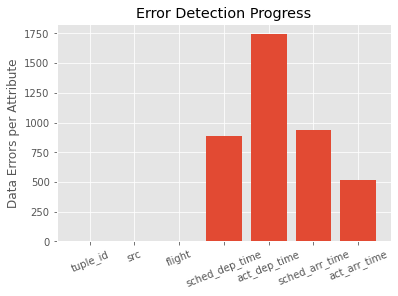

In [20]:
errors_per_attribute = d.dataframe.shape[1] * [0]
for cell in d.detected_cells:
    errors_per_attribute[cell[1]] += 1

plt.style.use("ggplot")
fig = plt.figure()
ax = plt.axes()
x_pos = range(len(d.dataframe.columns))
ax.bar(x_pos, errors_per_attribute)
ax.set(ylabel="Data Errors per Attribute", title="Error Detection Progress");
ax.set_xticks(numpy.arange(len(x_pos)))
_ = ax.set_xticklabels(d.dataframe.columns, rotation=22)

## 9. Initializing and Updating the Error Corrector Models
Baran initializes the error corrector models. Baran then iteratively samples a tuple. We should label data cells of each sampled tuple. It then udpates the models accordingly and generates a feature vector for each pair of a data error and a correction candidate. Finally, it trains and applies a classifier to each data column to predict the final correction of each data error. Since we already labeled tuples for Raha, we use the same labeled tuples and do not label new tuples here.

In [21]:
corrections_per_labels = [0]
app_2.initialize_models(d)
app_2.initialize_dataset(d)
for si in d.labeled_tuples:
    d.sampled_tuple = si
    app_2.update_models(d)
    app_2.predict_corrections(d)
    corrections_per_labels.append(len(d.corrected_cells))

The error corrector models are initialized.
The error corrector models are updated with new labeled tuple 2087.
Predicting module...
------------------------------------------------------------------------
1/4 columns(sched_dep_time)
Generating train features(7) ...
592 pairs of (a data error, a potential correction) are featurized.
Training classifier ...
Predicting corrections...
------------------------------------------------------------------------
2/4 columns(act_dep_time)
Generating train features(15) ...
1178 pairs of (a data error, a potential correction) are featurized.
Training classifier ...
Predicting corrections...
------------------------------------------------------------------------
3/4 columns(sched_arr_time)
Generating train features(10) ...
1550 pairs of (a data error, a potential correction) are featurized.
Training classifier ...
Predicting corrections...
------------------------------------------------------------------------
4/4 columns(act_arr_time)
Generating

In [22]:
def callback(data_cell):
    c = tuple(json.loads(data_cell))
    selected_tuple = pandas.DataFrame(data=[d.dataframe.iloc[c[0], :]], columns=d.dataframe.columns)
    IPython.display.display(selected_tuple)    
    features_df = pandas.DataFrame(columns=["Erroneus Value", "Correction", "Model", "Probability"])
    correction = d.corrected_cells[c]
    error_dictionary = {"column": c[1], "old_value": d.dataframe.iloc[c], "vicinity": list(d.dataframe.iloc[c[0], :])}
    value_corrections = app_2._value_based_corrector(d.value_models, error_dictionary)
    vicinity_corrections = app_2._vicinity_based_corrector(d.vicinity_models, error_dictionary)
    domain_corrections = app_2._domain_based_corrector(d.domain_models, error_dictionary)
    models_corrections = value_corrections + vicinity_corrections + domain_corrections
    for mi, model in enumerate(models_corrections):
        p = 0
        if correction in model:
            p = model[correction]
        name = ""
        if mi == len(models_corrections) - 1:
            name = "Domain " + d.dataframe.columns[c[1]]
        elif mi < len(model_names):
            name = model_names[mi]
        else:
            name = "{} -> {}".format(d.dataframe.columns[mi - 8], d.dataframe.columns[c[1]])
            
        features_df = pandas.concat([features_df, pandas.DataFrame({"Erroneus Value": d.dataframe.iloc[c], "Correction": correction,
                                          "Model": name, "Probability": "{:.2f}".format(p)}, index=[0])], ignore_index=True)
    IPython.display.display(features_df)
    
    column = c[1]
    features = d.column_features[column]
    features = (features - features.min())/(features.max() - features.min())
    pca = sklearn.decomposition.PCA(n_components=2)
    transformed = pandas.DataFrame(pca.fit_transform(features))
    clean_indexes = [True if (i, column) not in d.detected_cells else False for i in range(d.dataframe.shape[0])]
    clean_data_cells = transformed[clean_indexes]
    dirty_indexes = [True if (i, column) in d.detected_cells else False for i in range(d.dataframe.shape[0])]
    dirty_data_cells = transformed[dirty_indexes]
    selected_dirty_indexes = [True if i == c[0] else False for i in range(d.dataframe.shape[0])]
    selected_dirty_data_cell = transformed[selected_dirty_indexes]

    plt.style.use("ggplot")
    fig = plt.figure()
    ax = plt.axes()
    plt.scatter(clean_data_cells[0], clean_data_cells[1], label="Clean Data Cells", c="green")
    plt.scatter(dirty_data_cells[0], dirty_data_cells[1], label="Dirty Data Cells", c="red")
    plt.scatter(selected_dirty_data_cell[0], selected_dirty_data_cell[1], label="Selected Dirty Data Cells", c="blue")
    plt.legend()
    plt.show()
                            
                
_ = ipywidgets.interact(callback, data_cell=[json.dumps(cell) for cell in d.corrected_cells])

interactive(children=(Dropdown(description='data_cell', options=('[845, 3]', '[857, 3]', '[1409, 3]', '[1420, …

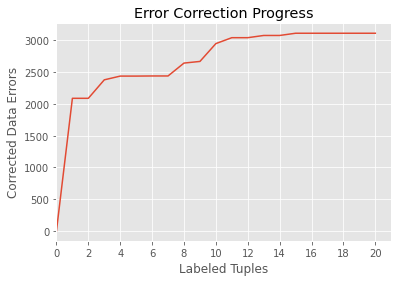

In [23]:
plt.style.use("ggplot")
fig = plt.figure()
ax = plt.axes()
ax.plot(range(0, len(d.labeled_tuples) + 1), corrections_per_labels)
_ = ax.set(xlim=(0, len(d.labeled_tuples) + 1), xticks = range(0, len(d.labeled_tuples) + 1, 2), 
       xlabel="Labeled Tuples", ylabel="Corrected Data Errors", title="Error Correction Progress")

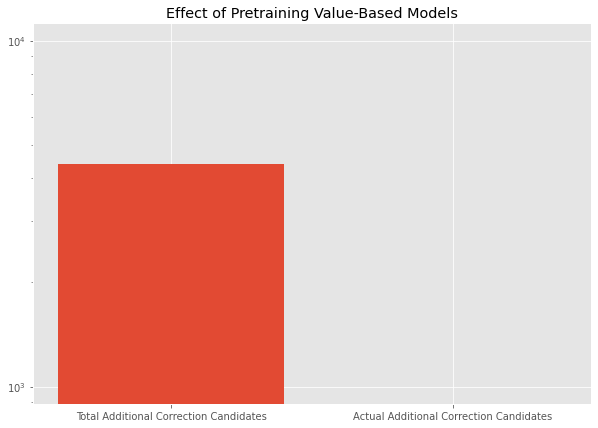

In [24]:
correction_candidates = {}
total_correction_candidates = 0
actual_correction_candidates = 0
for cell in d.detected_cells:
    correction_candidates[cell] = {}
    error_dictionary = {"column": cell[1], "old_value": d.dataframe.iloc[cell], "vicinity": list(d.dataframe.iloc[cell[0], :])}
    value_corrections = app_2._value_based_corrector(pretrained_models, error_dictionary)
    for model in value_corrections:
        for value in model:
            correction_candidates[cell][value] = 1
            total_correction_candidates += 1
            if value == d.clean_dataframe.iloc[cell]:
                actual_correction_candidates += 1

plt.style.use("ggplot")
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()
x_pos = [0, 1]
ax.bar(x_pos, [total_correction_candidates, actual_correction_candidates])
ax.set_yscale("log")
ax.set(title="Effect of Pretraining Value-Based Models");
ax.set_xticks(numpy.arange(len(x_pos)))
_ = ax.set_xticklabels(["Total Additional Correction Candidates", "Actual Additional Correction Candidates"], rotation=0)

## 10. Storing Results
Both Raha and Baran can also store the error detection/correction results.

In [25]:
app_1.store_results(d)
app_2.store_results(d)

The results are stored in ../datasets/flights/raha-baran-results-flights/error-detection/detection.dataset.
The results are stored in ../datasets/flights/raha-baran-results-flights/error-correction/correction.dataset.


## 11. Evaluating the Data Cleaning Task
We can finally evaluate our data cleaning task.

In [26]:
edp, edr, edf = d.get_data_cleaning_evaluation(d.detected_cells)[:3]
ecp, ecr, ecf = d.get_data_cleaning_evaluation(d.corrected_cells)[-3:]

evaluation_df = pandas.DataFrame(columns=["Task", "Precision", "Recall", "F1 Score"])
evaluation_detection_df = pandas.DataFrame({"Task": "Error Detection (Raha)", "Precision": "{:.2f}".format(edp), "Recall": "{:.2f}".format(edr), "F1 Score": "{:.2f}".format(edf)}, index=[0])
evaluation_correction_df = pandas.DataFrame({"Task": "Error Correction (Baran)", "Precision": "{:.2f}".format(ecp), "Recall": "{:.2f}".format(ecr), "F1 Score": "{:.2f}".format(ecf)}, index=[0])
evaluation_df = pandas.concat([evaluation_df, evaluation_detection_df, evaluation_correction_df], ignore_index=True)
evaluation_df.head()

,Task,Precision,Recall,F1 Score
0,Error Detection (Raha),0.86,0.71,0.78
1,Error Correction (Baran),0.78,0.49,0.60
